In [1]:
import argparse
import numpy as np
import os
from math import log10, floor
from datetime import datetime
from glob import glob
import stat
import pickle
import math
import array
import scipy
from multiprocessing import Pool
from itertools import repeat
from pathlib import Path
from scipy.signal import correlate
from scipy.fft import ifft, fft, next_fast_len
import qetpy as qp
import matplotlib
import matplotlib.pyplot as plt
import pytesdaq.io.hdf5 as h5io
import pytesdaq
from detprocess.core import OptimumFilterTrigger, EventBuilder, Template, Noise
from detanalysis import PhotonCalibration
from pprint import pprint
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle as pkl
import sys


/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/site-packages/pytz/__init__.py:499: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/share/zoneinfo/zone.tab' mode='r' encoding='UTF-8'>
  for l in open(os.path.join(_tzinfo_dir, 'zone.tab'))
/home/mwilliams/.local/lib/python3.6/site-packages/paramiko/transport.py:32: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core 

Wakepy using: jeepney (dbus)


/usr/lib64/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/mwilliams/.local/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)


## Below is the original salting function written by Xinran for the old processing code that was once in pytesdaq. Now the processing code is in detprocess and is compeltely different. The goal is to slowly morph the following cell into an up to date and integratable version for the modern infrastructure

### The function _sim_inject_single_trace was called when the _acquire_trigger function was called with the proper arguments

In [2]:
#lets read in some continuous data from pyle lab run 44
# Instantiate raw data reader
channels = ['Mv3025pcBigFins','Mv3025pcRegular']
continuous_data_path = '/sdata1/runs/run46/raw/continuous_I2_D20240620_T165135'
continuous_data_series = 'I2_D20240620_T165258'
h5 = h5io.H5Reader()
h5.set_files(continuous_data_path, series=continuous_data_series)
mtraces, mtraces_info = h5.read_many_events(nevents=7, detector_chans=channels, include_metadata=True, adctoamp=True)

INFO: Found total of 3 raw data file(s) from 1 different series number!
INFO: Found total of 3 files from 1 different series number!
INFO Node #1: Acquiring randoms for series I2_D20240620_T165258
INFO: Randoms acquisition done!
INFO: Processing PSD for channel Mv3025pcBigFins
INFO: 930 events found in raw data for channel(s) Mv3025pcBigFins
INFO: Number of events after cuts = 233, efficiency = 25.05%
INFO: Processing PSD for channel Mv3025pcRegular
INFO: 930 events found in raw data for channel(s) Mv3025pcRegular
INFO: Number of events after cuts = 194, efficiency = 20.86%


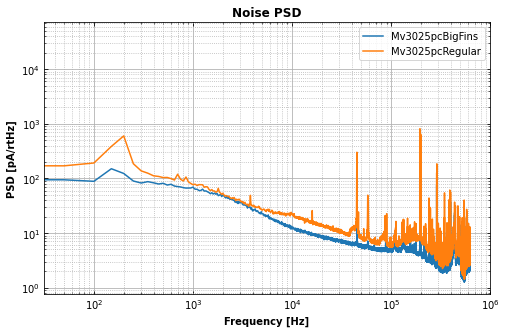

In [3]:
noise = Noise(verbose=True)
noise.generate_randoms(continuous_data_path, series=continuous_data_series, 
                       nevents=1000, min_separation_msec=100, ncores=1)
trace_length_msec = 20
pretrigger_length_msec = 10


# calculate PSD
noise.calc_psd(channels,
               nevents=1000,
               trace_length_msec=trace_length_msec, 
               pretrigger_length_msec=pretrigger_length_msec)

# displays
noise.plot_psd(channels)

# get values
psd_Mv3025pcBigFins, psd_freq = noise.get_psd('Mv3025pcBigFins')
psd_Mv3025pcRegular, psd_freq = noise.get_psd('Mv3025pcRegular')
fs = noise.get_sample_rate()

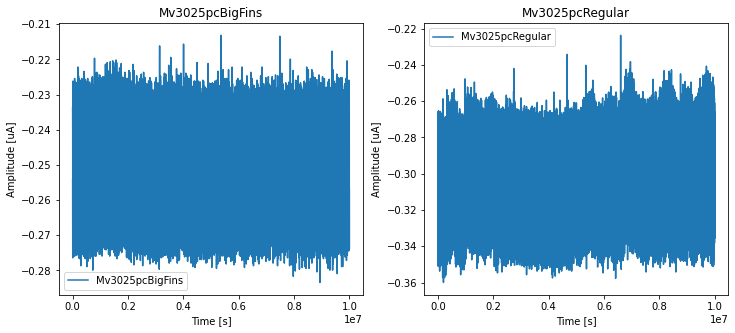

In [4]:
# let's select an event
traces = mtraces[3]
info = mtraces_info[3]
fs = info['sample_rate']
dt = 1/fs
bins = np.asarray(list(range(traces.shape[-1])))*dt*1e6

# display
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
for it in range(len(channels)):
    ax[it].plot(bins, traces[it,:]*1e6, label=channels[it])
    ax[it].legend()
    ax[it].set_title(channels[it])
    ax[it].set_xlabel("Time [s]")
    ax[it].set_ylabel("Amplitude [uA]")

In [5]:
info

{'event_id': 4,
 'event_index': 4,
 'event_num': 100004,
 'event_time': 1718927620,
 'comment': 'laser off ',
 'daq_version': '1.0.0',
 'data_prefix': 'cont',
 'data_purpose': 'Test',
 'dump_num': 1,
 'facility': 2,
 'format_version': '1.0.0',
 'fridge_run': 46,
 'fridge_run_start': 1718636400,
 'group_comment': '"laser off"',
 'group_name': 'continuous_I2_D20240620_T165135',
 'group_start': 1718927496,
 'prefix': '/sdata/runs/run46/raw/continuous_I2_D20240620_T165135/cont',
 'restricted': 0,
 'run_purpose': 'Test',
 'run_type': 'Test',
 'series_num': 220240620165258,
 'series_start': 1718927578,
 'timestamp': 1718927578,
 'adc_channel_indices': [2, 3],
 'adc_conversion_factor': array([[-2.1768620e-03,  1.5620886e-04,  1.8947182e-14,  1.9860906e-18],
        [ 8.3860796e-04,  1.5626207e-04,  1.2102963e-14,  1.1442504e-18]],
       dtype=float32),
 'connection0': array(['detector:Mv3TESs4pc', 'tes:A', 'controller:feb1_A'], dtype='<U19'),
 'connection1': array(['detector:Mv3TESs800x200',

Calculating dPdI! This may take some time.


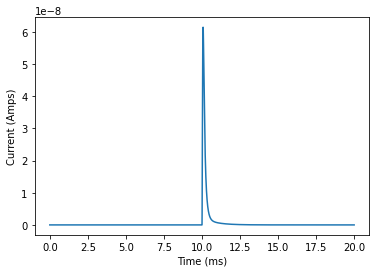

Calculating dPdI! This may take some time.


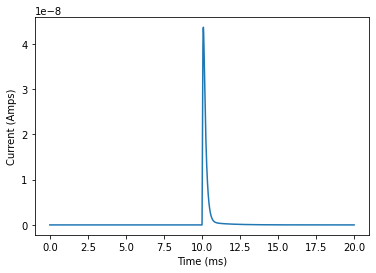

In [6]:
with open("/sdata1/runs/run46/processed/didvs/didvresult_Mv3025pcBigFins_0624", 'rb') as handle:
    didv_bigfins = pickle.load(handle)
    
with open("/sdata1/runs/run46/processed/didvs/didvresult_Mv3025pcRegular_0624", 'rb') as handle:
    didv_regfins = pickle.load(handle)
    
    #phonon veto calibration object
with open("/sdata1/runs/run46/processed/photon_calibrations/photoncal_025pcBigFins_062624_405", 'rb') as handle:
    cal_bigfins = pickle.load(handle)
    
#tes calibration object
with open("/sdata1/runs/run46/processed/photon_calibrations/photoncal_025pcRegular_062624_405", 'rb') as handle:
    cal_regfins = pickle.load(handle)
    
    
t_arr = np.arange(0, 20e-3 - 0.5/(1.25e6),
                  1/(1.25e6))
start_time = 10e-3

template_big, time_array = cal_bigfins.get_current_template(2, didv_bigfins, t_arr, start_time=start_time)

template_reg, time_array = cal_regfins.get_current_template(2, didv_regfins, t_arr, start_time=start_time)

In [7]:
pretrigger_length_msec = 10
pretrigger_sample = int(pretrigger_length_msec*1e-3*fs)

OF_Mv3025pcBigFins = OptimumFilterTrigger(channels[0], fs,template_big, 
                                        psd_Mv3025pcBigFins,pretrigger_sample)
OF_Mv3025pcRegular = OptimumFilterTrigger(channels[1], fs,template_reg, 
                                        psd_Mv3025pcRegular,pretrigger_sample)

In [8]:
res = OF_Mv3025pcBigFins.get_resolution()

In [9]:
res

0.04885426875065252

In [10]:
OF_Mv3025pcBigFins.update_trace(traces[0,:])
OF_Mv3025pcRegular.update_trace(traces[1,:])

In [11]:
filtered_trace = np.zeros_like(traces)
filtered_trace[0,:] = OF_Mv3025pcBigFins._filtered_trace
filtered_trace[1,:] = OF_Mv3025pcRegular._filtered_trace

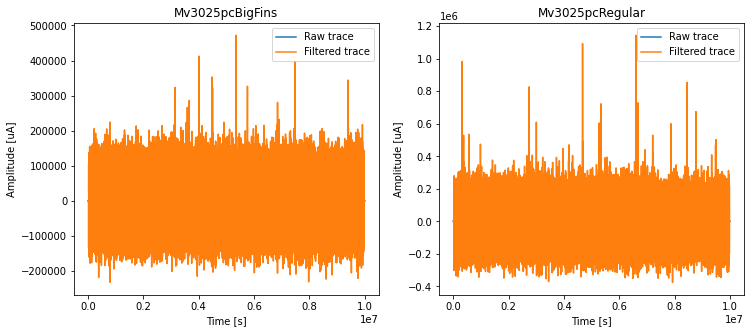

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
for it in range(len(channels)):
    ax[it].plot(bins, traces[it]*1e6, label='Raw trace')
    ax[it].plot(bins, filtered_trace[it,:]*1e6, label='Filtered trace')
    ax[it].legend()
    ax[it].set_title(channels[it])
    ax[it].set_xlabel("Time [s]")
    ax[it].set_ylabel("Amplitude [uA]")

In [13]:
sim_energies=[0.5,0.3]
nsim = 10
coincident_window = 500e-6

In [18]:
def _sim_inject_single_trace(self, trace, filteredTrace, nsim, energies, traces_norm, TES_energy_scale, coincident_window, usetemplate=False, pulses=None):
        """
        trace is 2d array: #channels, #bins
        """
        #inject simulated pulse to trace! energies in eV
        newtrace = np.array(trace,copy=True) #make an exact copy of the original input trace
        newfilteredTrace = np.array(filteredTrace, copy=True) #make a copy of the trace as returned from the OF
        salts_before_ADC=np.zeros(trace.shape,dtype=float) #make an array the same length as the trace. Here is where we will inject the salt
        salts_filtered  =np.zeros(trace.shape,dtype=float) #make an array the same length as the trace. This is where we put the salts after they are filtered
        #random times
        if pulses is not None: #pulses is an array Nd array where N is number of pulses and each "pulse" array is a trace with a pulse(?)
            if len(pulses)!=nsim :
                raise ValueError('ERROR: unexpected slats vector length!')
            simTime = np.transpose(pulses)[0].astype(int)
            energy = np.transpose(pulses)[1]
        else:
            simTime = np.random.rand(nsim) #randomly select a time between 0 and 1 to place the salt
            #scale to the total trace length, leave coincident_window samples margin to the end.
            coincident_window_bin=int(coincident_window*self._sample_rate)+1 #take the coincident_window in units of us and convert it to n samples
            simTime *= trace[0].size - self._nb_samples*2 - coincident_window_bin - coincident_window_bin*nsim # take that simTime and scale it to trace length -???
            #offset adjacent salts with coincident_window_bin samples, such that when matching trigger time to sim truth the salts do not mix.
            simTime = np.sort(simTime) + np.arange(nsim)*coincident_window_bin 
            simTime = simTime.astype(int)
            simTime += self._nb_samples//2
            #Sample energy in eV,
            energy = np.random.choice(energies,nsim)

        simAmp = []
        for ichan in range(trace.shape[0]) :
            if ichan>0 :
                print("Warning! Salting for multichannel not implemented!")
            else :
                #prepare pulse shape, use the filter template by default.
                template = self._filter_dict['template'][ichan] #this is the template you give the OF
                filttemplate = self._filter_dict['filttemplate'][ichan] #this is the template after the OF???

                #if usetemplate or True :
                #else :
                #    #construct pulse shape with rise and fall times.
                #    print("to be implemented")

                # scale to Amp
                if traces_norm is None : #what norm is this? Norm of the OF amp? adc to miliamp
                    template_amp = template
                else :
                    p = np.poly1d(traces_norm[ichan]) #FIXME!! for multiple channels, norm is an array of triggering channels, not all channels.
                    template_amp = p(template+newtrace[ichan][0]) #normalize the template pulse+actual trace values
                    template_amp -= template_amp[0] #subtract the baseline
                template_amp_amplitude = max(template_amp) #take the largest amplitude from the trace and call it the amplitude
                # scale to the sim energy
                vb_corr=TES_energy_scale['TES_vb']-2*TES_energy_scale['TES_i0']*TES_energy_scale['TES_rl']
                rl=TES_energy_scale['TES_rl']
                e_init = np.trapz(template_amp*vb_corr - template_amp*template_amp*rl, dx=1./self._sample_rate) * 6.242e18 # convert to energy

                for isim, amplitude_e in enumerate(energy* TES_energy_scale['detector_eff']):#detector_eff = PCE
                    template_scaled = (template/e_init * amplitude_e) #.astype(int) #DO digitization in the end!
                    filttemplate_scaled = filttemplate * energy[isim] 
                    simAmp.append(template_amp_amplitude/e_init * amplitude_e)
                    if self._is_negative_pulse:
                        template_scaled *= -1
                        filttemplate_scaled *= -1
                    ## offset to the sampled time
                    salts_before_ADC[ichan,simTime[isim]:simTime[isim]+self._nb_samples] += template_scaled
                    salts_filtered  [ichan,simTime[isim]-self._nb_samples//2+1:simTime[isim]+self._nb_samples+self._nb_samples//2] += filttemplate_scaled
        #simulate the digitization: randomize the digits of each sample of the salt
        salts_after_ADC=np.floor(salts_before_ADC).astype(int)
        newtrace += salts_after_ADC
        newtrace += (salts_before_ADC-salts_after_ADC-np.random.random_sample(trace.shape))>0
        newfilteredTrace += salts_filtered
        simPulses = np.transpose([simTime,energy,simAmp])
        return newtrace, newfilteredTrace, simPulses

In [19]:

def _sim_inject_single_trace(trace,metadata,time_array, OF, nsim, energies, didv_result,template, coincident_window, usetemplate=False, pulses=None):
        """
        trace is 2d array: #channels, #bins
        """
        #inject simulated pulse to trace! energies in eV
        newtrace = np.array(trace,copy=True)
        OF.update_trace(trace[0])
        filtered_trace = np.zeros_like(trace)
        filtered_trace[0] = OF._filtered_trace
        newfilteredTrace = np.array(filtered_trace, copy=True)
        salts_before_ADC=np.zeros(trace.shape,dtype=float)
        salts_filtered  =np.zeros(trace.shape,dtype=float)
        nb_samples=len(template)
        #random times
        if pulses is not None:
            if len(pulses)!=nsim :
                raise ValueError('ERROR: unexpected slats vector length!')
            simTime = np.transpose(pulses)[0].astype(int)
            energy = np.transpose(pulses)[1]
        else:
            simTime = np.random.rand(nsim)
            #scale to the total trace length, leave coincident_window samples margin to the end.
            coincident_window_bin=int(coincident_window*info['sample_rate'])+1
            simTime *= trace[0].size - nb_samples*2 - coincident_window_bin - coincident_window_bin*nsim
            #offset adjacent salts with coincident_window_bin samples, such that when matching trigger time to sim truth the salts do not mix.
            simTime = np.sort(simTime) + np.arange(nsim)*coincident_window_bin 
            simTime = simTime.astype(int)
            simTime += nb_samples//2
            #Sample energy in eV,
            energy = np.random.choice(energies,nsim)

        simAmp = []
        for ichan in range(trace.shape[0]) :
            if ichan>0 :
                print("Warning! Salting for multichannel not implemented!")
            else :
                #prepare pulse shape, use the filter template by default.
                #template = self._filter_dict['template'][ichan]
                #filttemplate = self._filter_dict['filttemplate'][ichan]
                template = template
                filttemplate = correlate(template,OF.get_phi(),mode="full",method='fft')/OF.get_norm()

                #if usetemplate or True :
                #else :
                #    #construct pulse shape with rise and fall times.
                #    print("to be implemented")

                # scale to Amp
                p = np.poly1d(metadata['adc_conversion_factor'][0]) 
                template_amp = p(template+newtrace[ichan][0])
                template_amp -= template_amp[0]
                template_amp_amplitude = max(template_amp)
                # scale to the sim energy
                vb_corr=(didv_result['biasparams']['ibias']*didv_result['biasparams']['rsh'])-2*didv_result['biasparams']['i0']*didv_result['biasparams']['rl']
                rl=didv_result['biasparams']['rl']
                e_init = qp.get_energy_normalization(time_array, template, didv_result=didv_bigfins, lgc_ev=True)
                #e_init = np.trapz(template_amp*vb_corr - template_amp*template_amp*rl, dx=1./self._sample_rate) * 6.242e18 #FIXME!! Hard coded number!
                resolution = OF.get_resolution()

                for isim, amplitude_e in enumerate(energy* 0.5):
                    template_scaled = (template/e_init * amplitude_e) #.astype(int) #DO digitization in the end!
                    filttemplate_scaled = filttemplate * energy[isim] 
                    simAmp.append(template_amp_amplitude/e_init * amplitude_e)
                    #if self._is_negative_pulse:
                    #    template_scaled *= -1
                    #    filttemplate_scaled *= -1
                    ## offset to the sampled time
                    salts_before_ADC[ichan,simTime[isim]:simTime[isim]+nb_samples] += template_scaled
                    salts_filtered  [ichan,simTime[isim]-nb_samples//2+1:simTime[isim]+nb_samples+nb_samples//2] += filttemplate_scaled
        #simulate the digitization: randomize the digits of each sample of the salt
        salts_after_ADC=np.floor(salts_before_ADC).astype(int)
        newtrace += salts_after_ADC
        newtrace += (salts_before_ADC-salts_after_ADC-np.random.random_sample(trace.shape))>0
        newfilteredTrace += salts_filtered
        simPulses = np.transpose([simTime,energy,simAmp])
        return newtrace, newfilteredTrace, simPulses

In [20]:
traces_norm = [1e-6,1e-6]

In [21]:
newtrace,newfilteredTrace, simPulses = _sim_inject_single_trace(trace,info,time_array, OF_melange25pc1ch, nsim, sim_energies, didv_bigfins,template_big, coincident_window, usetemplate=False, pulses=None)

In [22]:
newtrace

array([[-2.54166937e-07, -2.55416608e-07, -2.54416871e-07, ...,
        -2.59165621e-07, -2.52167463e-07, -2.56916213e-07]])

No handles with labels found to put in legend.


Text(0, 0.5, 'Amplitude [uA]')

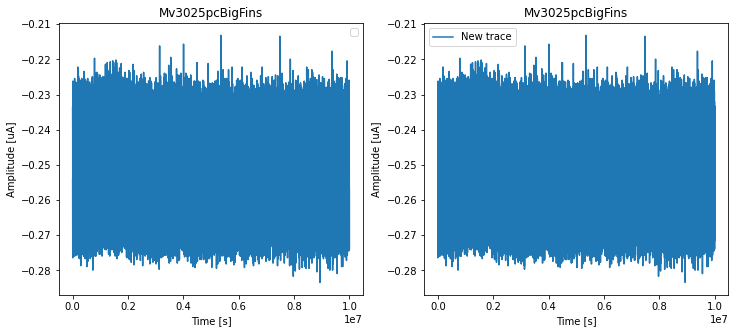

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].legend()
ax[0].set_title(channels[0])
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Amplitude [uA]")
ax[0].plot(bins, trace[0,:]*1e6, label='Raw trace')
ax[1].plot(bins, newtrace[0,:]*1e6, label='New trace')
ax[1].legend()
ax[1].set_title(channels[0])
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Amplitude [uA]")

No handles with labels found to put in legend.


Text(0, 0.5, 'Amplitude [uA]')

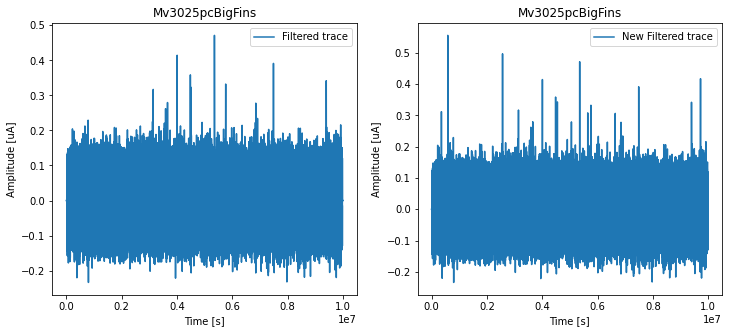

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].legend()
ax[0].set_title(channels[0])
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Amplitude [uA]")
ax[0].plot(bins, filtered_trace[0,:], label='Filtered trace')
ax[0].legend()
ax[1].plot(bins, newfilteredTrace[0,:], label='New Filtered trace')
ax[1].legend()
ax[1].set_title(channels[0])
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Amplitude [uA]")

## Now make the salting work for two channels, in the most simple way

In [14]:
ofarray = [OF_Mv3025pcBigFins,OF_Mv3025pcRegular]
templatearray = [template_big,template_reg]
didvarray = [didv_bigfins,didv_regfins]
PCEarray=[0.4,0.3]

In [15]:
ofarray[0]

In [16]:
testing = ofarray[0].get_resolution()
print(testing)

0.04885426875065252


In [17]:

def _sim_inject_single_trace(trace,metadata,time_array, OF,PCE, nsim, energies, didv_result,templates, coincident_window, usetemplate=False, pulses=None):
        """
        trace is 2d array: #channels, #bins
        """
        #inject simulated pulse to trace! energies in eV
        newtrace = np.array(trace,copy=True)
        filtered_trace = np.zeros_like(trace)
        salts_before_ADC=np.zeros(trace.shape,dtype=float)
        salts_filtered  =np.zeros(trace.shape,dtype=float)
        nb_samples=len(templates[0])
        #random times
        if pulses is not None:
            if len(pulses)!=nsim :
                raise ValueError('ERROR: unexpected slats vector length!')
            simTime = np.transpose(pulses)[0].astype(int)
            energy = np.transpose(pulses)[1]
        else:
            simTime = np.random.rand(nsim)
            #scale to the total trace length, leave coincident_window samples margin to the end.
            coincident_window_bin=int(coincident_window*info['sample_rate'])+1
            simTime *= trace[0].size - nb_samples*2 - coincident_window_bin - coincident_window_bin*nsim
            #offset adjacent salts with coincident_window_bin samples, such that when matching trigger time to sim truth the salts do not mix.
            simTime = np.sort(simTime) + np.arange(nsim)*coincident_window_bin 
            simTime = simTime.astype(int)
            simTime += nb_samples//2
            #Sample energy in eV,
            energy = np.random.choice(energies,nsim)

        simAmp = []
        for ichan in range(trace.shape[0]) :
            print("TESTING MULTCHANNEL SALT")
            print(ichan)
            #prepare pulse shape, use the filter template by default.
            #template = self._filter_dict['template'][ichan]
            #filttemplate = self._filter_dict['filttemplate'][ichan]
            optimumfilter=OF[ichan]
            optimumfilter.update_trace(trace[ichan,:])
            filtered_trace[ichan,:] = optimumfilter._filtered_trace
            newfilteredTrace = np.array(filtered_trace, copy=True)
            template = templates[ichan]
            print(len(template))
            print(len(optimumfilter.get_phi()))
            filttemplate = correlate(template,optimumfilter.get_phi(),mode="full",method='fft')/optimumfilter.get_norm() #replace!!!

            #if usetemplate or True :
            #else :
            #    #construct pulse shape with rise and fall times.
            #    print("to be implemented")

            # scale to Amp
            p = np.poly1d(metadata['adc_conversion_factor'][0]) 
            template_amp = p(template+newtrace[ichan][0])
            template_amp -= template_amp[0]
            template_amp_amplitude = max(template_amp)
            # scale to the sim energy
            e_init = qp.get_energy_normalization(time_array, template, didv_result=didv_result[ichan], lgc_ev=True)
            

            for isim, amplitude_e in enumerate(energy* PCE[ichan]):
                print("starting for loop...")
                print(len(filttemplate))
                template_scaled = (template[ichan]/e_init * amplitude_e) #.astype(int) #DO digitization in the end!
                filttemplate_scaled = filttemplate * energy[isim] 
                simAmp.append(template_amp_amplitude/e_init * amplitude_e)
                #if self._is_negative_pulse:
                #    template_scaled *= -1
                #    filttemplate_scaled *= -1
                ## offset to the sampled time
                salts_before_ADC[ichan,simTime[isim]:simTime[isim]+nb_samples] += template_scaled
                salts_filtered[ichan,simTime[isim]-nb_samples//2+1:simTime[isim]+nb_samples+nb_samples//2] += filttemplate_scaled
        #simulate the digitization: randomize the digits of each sample of the salt
        salts_after_ADC=np.floor(salts_before_ADC).astype(int)
        newtrace += salts_after_ADC
        newtrace += (salts_before_ADC-salts_after_ADC-np.random.random_sample(trace.shape))>0
        newfilteredTrace += salts_filtered
        simPulses = np.transpose([simTime,energy,simAmp])
        return newtrace, newfilteredTrace, simPulses

In [18]:
newtrace,newfilteredTrace, simPulses = _sim_inject_single_trace(traces,info,time_array, ofarray,PCEarray, nsim, sim_energies, didvarray,templatearray, coincident_window, usetemplate=False, pulses=None)

TESTING MULTCHANNEL SALT
0
25000
25000
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
TESTING MULTCHANNEL SALT
1
25000
25000
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0, 0.5, 'Amplitude [uA]')

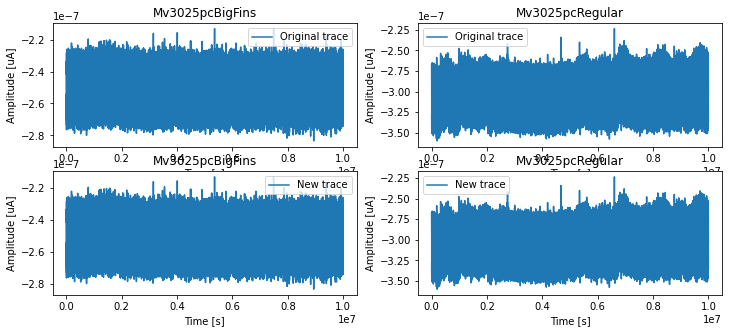

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,5))
ax[0,0].legend()
ax[0,0].set_title(channels[0])
ax[0,0].set_xlabel("Time [s]")
ax[0,0].set_ylabel("Amplitude [uA]")
ax[0,0].plot(bins, traces[0,:], label='Original trace')
ax[0,0].legend()
ax[1,0].plot(bins, newtrace[0,:], label='New trace')
ax[1,0].legend()
ax[1,0].set_title(channels[0])
ax[1,0].set_xlabel("Time [s]")
ax[1,0].set_ylabel("Amplitude [uA]")

ax[0,1].legend()
ax[0,1].set_title(channels[1])
ax[0,1].set_xlabel("Time [s]")
ax[0,1].set_ylabel("Amplitude [uA]")
ax[0,1].plot(bins, traces[1,:], label='Original trace')
ax[0,1].legend()
ax[1,1].plot(bins, newtrace[1,:], label='New trace')
ax[1,1].legend()
ax[1,1].set_title(channels[1])
ax[1,1].set_xlabel("Time [s]")
ax[1,1].set_ylabel("Amplitude [uA]")

No handles with labels found to put in legend.


No handles with labels found to put in legend.


Text(0, 0.5, 'Amplitude [uA]')

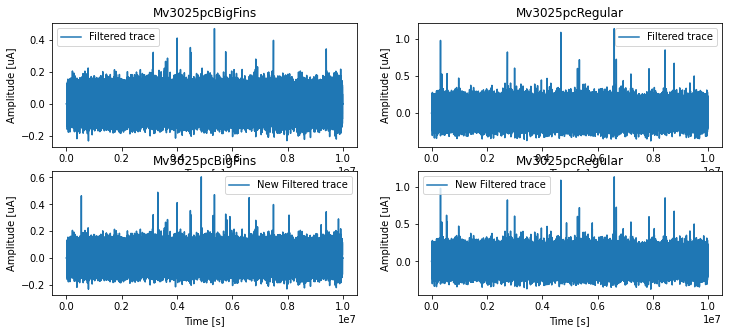

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,5))
ax[0,0].legend()
ax[0,0].set_title(channels[0])
ax[0,0].set_xlabel("Time [s]")
ax[0,0].set_ylabel("Amplitude [uA]")
ax[0,0].plot(bins, filtered_trace[0,:], label='Filtered trace')
ax[0,0].legend()
ax[1,0].plot(bins, newfilteredTrace[0,:], label='New Filtered trace')
ax[1,0].legend()
ax[1,0].set_title(channels[0])
ax[1,0].set_xlabel("Time [s]")
ax[1,0].set_ylabel("Amplitude [uA]")

ax[0,1].legend()
ax[0,1].set_title(channels[1])
ax[0,1].set_xlabel("Time [s]")
ax[0,1].set_ylabel("Amplitude [uA]")
ax[0,1].plot(bins, filtered_trace[1,:], label='Filtered trace')
ax[0,1].legend()
ax[1,1].plot(bins, newfilteredTrace[1,:], label='New Filtered trace')
ax[1,1].legend()
ax[1,1].set_title(channels[1])
ax[1,1].set_xlabel("Time [s]")
ax[1,1].set_ylabel("Amplitude [uA]")

In [30]:
def generate_gaussian_random_numbers(n, mean=0.5, std_dev=0.2):
    while True:
        # Generate random numbers from a Gaussian distribution
        random_numbers = np.random.normal(loc=mean, scale=std_dev, size=n)
        
        # Clip values to be between 0 and 1
        random_numbers = np.clip(random_numbers, 0, 1)
        
        # Check if the sum is positive (important for the normalization step)
        if np.sum(random_numbers) > 0:
            # Normalize to sum to 1
            random_numbers = random_numbers / np.sum(random_numbers)
            return random_numbers

n = 2  # Number of random numbers you want
random_numbers = generate_gaussian_random_numbers(n)
print(random_numbers)
print(f"Sum: {np.sum(random_numbers)}")  # This should print 1

[0.61586647 0.38413353]
Sum: 0.9999999999999999
